In [1]:
# https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
# pyimagesearch.com/2016/10/03/bubble-sheet-multiple-choice-scanner-and-test-grader-using-omr-python-and-opencv/

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
from collections import OrderedDict
import string
import math

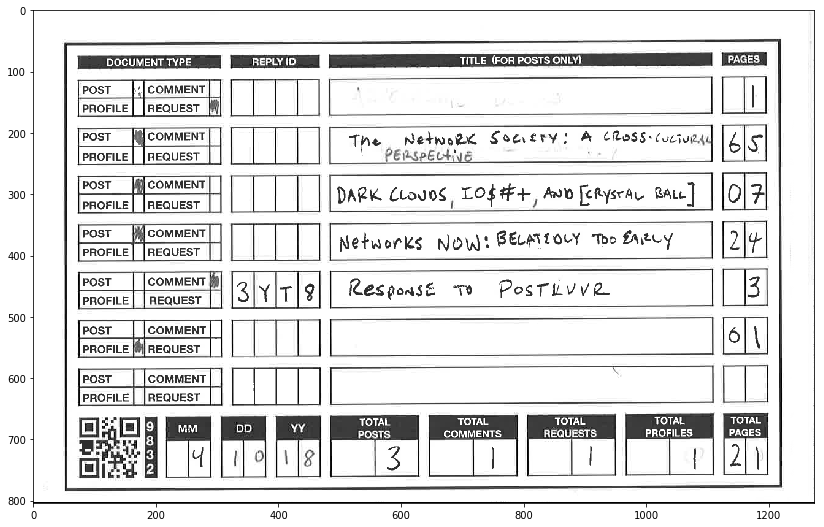

In [2]:
img_name = 'deposit_slip_test_top.png'
img_loc = 'data/'

img = cv2.imread(img_loc + img_name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (14,18))
plt.imshow(gray, 'gray')

#### FIND OUTER BOX CONTOUR

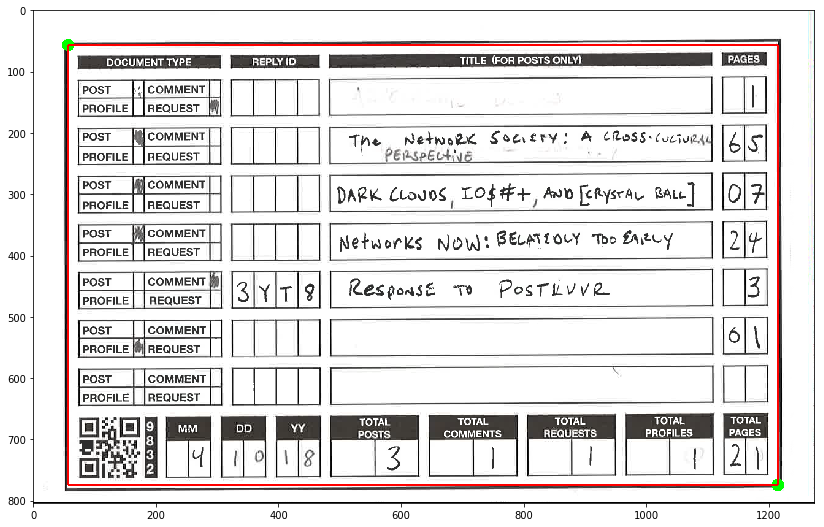

In [3]:
img_name = 'deposit_slip_test_top.png'
img_loc = 'data/'

img = cv2.imread(img_loc + img_name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 2)
edged = cv2.Canny(blurred, 25, 30, True)

im2, contours, hierarchy = cv2.findContours(edged,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# ensure that at least one contour was found

quad_contours = []
approxes = []

if len(contours) > 0:
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # loop over the sorted contours
    for contour in contours:
        # approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, .02 * peri, True)

        # if our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            quad_contours.append(approx)

cnt = quad_contours[3]
plt.figure(figsize = (14,18))
plt.imshow(cv2.drawContours(img, [cnt[3], cnt[1]], -1, (0,255,0), 20))
p1 = tuple(cnt[3][0])
p2 = tuple(cnt[1][0])
plt.imshow(cv2.rectangle(img, p1, p2, (255,0,0), 2))

#### CROP TO BOX

X1: 57 Y1: 57
X2: 1214 Y2: 774
(717, 1157, 3)


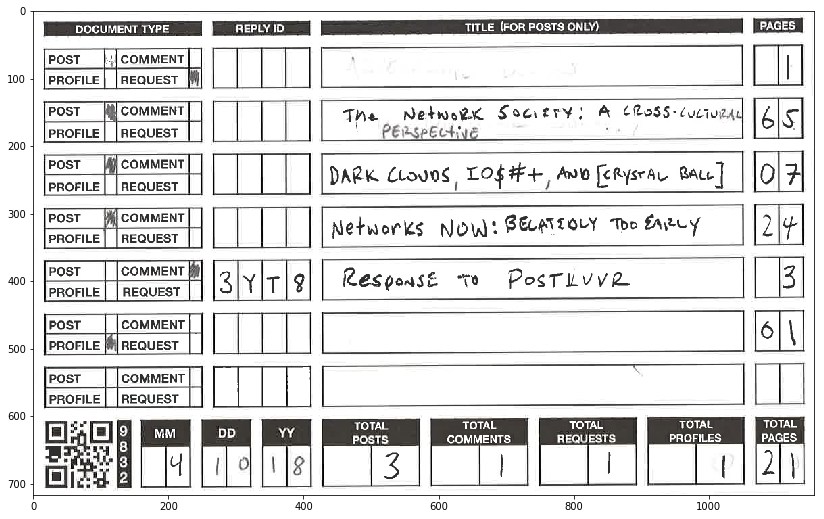

In [4]:
img_name = 'deposit_slip_test_top.png'
img_loc = 'data/'

img = cv2.imread(img_loc + img_name)

cnt = quad_contours[3]
p1 = tuple(cnt[3][0])
p2 = tuple(cnt[1][0])

# print p1, p2

x1 = p1[0]
y1 = p1[1]

x2 = p2[0]
y2 = p2[1]

print 'X1:', x1, 'Y1:', y1
print 'X2:', x2, 'Y2:', y2

box = img[y1:y2, x1:x2]
print box.shape
plt.figure(figsize = (14,18))
plt.imshow(box)

#### SPLIT INTO DOCUMENTS AND SUMMARY

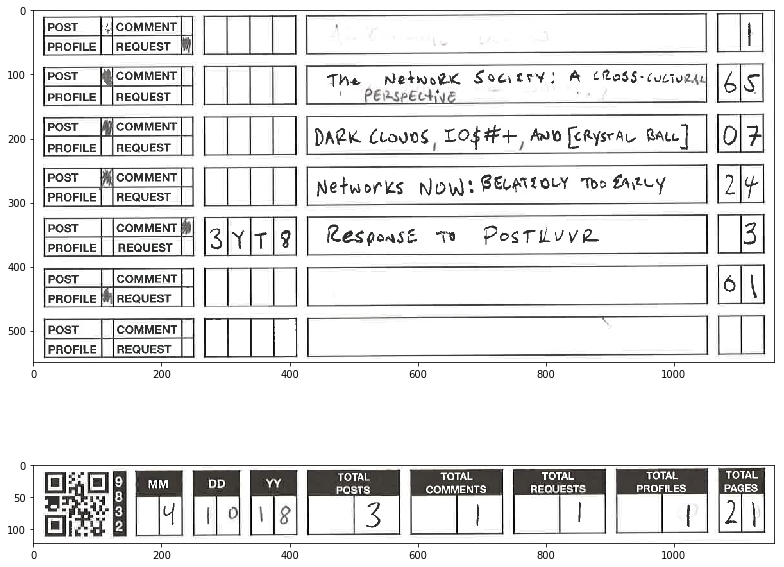

In [6]:
def get_docs_roi(deposit_slip, x1=0, y1=45, x2=1157, y2=595):

    docs_img = deposit_slip[y1:y2, x1:x2]
    
#     print 'X1:', x1, 'Y1:', y1
#     print 'X2:', x2, 'Y2:', y2
#     print totals_img.shape
    
    return docs_img

def get_summary_roi(deposit_slip, x1=0, y1=595, x2=1157, y2=717):

    summary_img = deposit_slip[y1:y2, x1:x2]
    
#     print 'X1:', x1, 'Y1:', y1
#     print 'X2:', x2, 'Y2:', y2
#     print totals_img.shape
    
    return summary_img

summary_img = get_summary_roi(box)
docs_img = get_docs_roi(box)

plt.figure(figsize=(11,10))

plt.subplot(2, 1, 1), plt.imshow(docs_img, 'gray')
plt.subplot(2, 1, 2), plt.imshow(summary_img, 'gray')
plt.tight_layout()

#### SPLIT INTO INDIVIDUAL DOCUMENTS

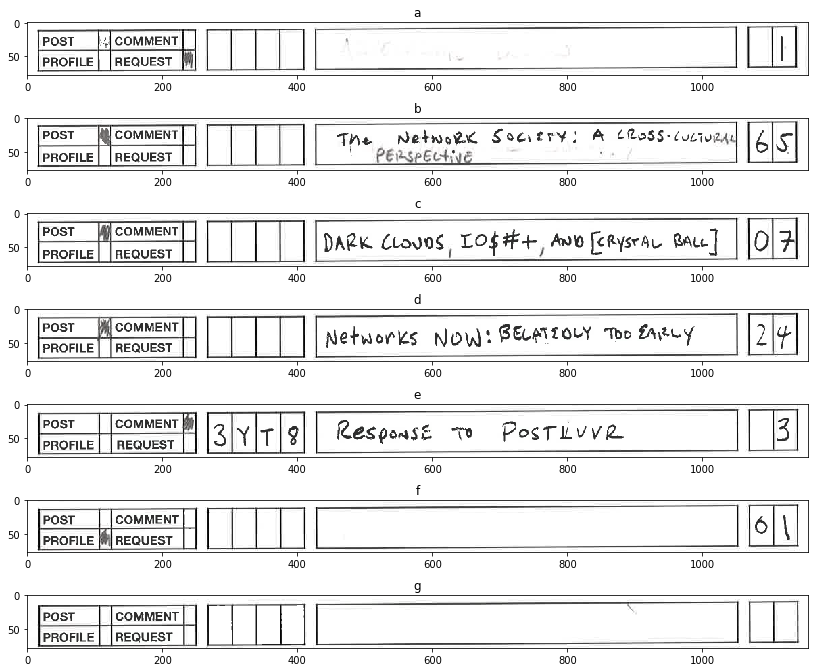

In [7]:
def split_docs_rois(docs_img, num_docs=7):
    
    width = docs_img.shape[1]
    height = docs_img.shape[0]

    doc_height = height/num_docs
    
    # abcdefghijklmnopqrstuvwxyz
    doc_ids = string.ascii_lowercase[:num_docs]

    docs = OrderedDict()

    for i, doc_id in zip(range(num_docs), doc_ids):

        x1 = 0
        y1 = i * doc_height

        x2 = width
        y2 = y1 + doc_height

        doc_img = docs_img[y1:y2, x1:x2]

        docs[doc_id] = {'full' : doc_img}
        
        #     print 'DOC ID:', doc_id
        #     print 'X1:', x1, 'Y1:', y1
        #     print 'X2:', x2, 'Y2:', y2
        #     print ''
    return docs

docs = split_docs_rois(docs_img, num_docs=7)

rows = 7
cols = 1

plt.figure(figsize=(14, 12))

for i, (doc_id, doc) in enumerate(docs.items()):

    plt.subplot(rows, cols, i + 1), plt.imshow(doc['full'])
    plt.title(doc_id)

#### SPLIT DOCUMENT INTO TYPE, REPLY ID, TITLE, AND NO. PAGES

In [32]:
def split_doc_rois(docs_imgs, widths):
    
    doc_w = docs_imgs['a']['full'].shape[1]
    doc_h = docs_imgs['a']['full'].shape[0]
    
    widths = widths + [doc_w]
    
    coords = [[(widths[i], 0), (widths[i + 1], doc_h)] for i in range(len(widths) -1)]
    parts = ['type', 'reply_id', 'title', 'pages']
    
    for ltr, doc in docs_imgs.items():
        
#         print 'DOCUMENT', ltr
        img_parts = []
    
        for coord, part in zip(coords, parts):

            x1, y1 = coord[0][0], coord[0][1]
            x2, y2 = coord[1][0], coord[1][1]

            doc_img = doc['full']
            part_roi = doc_img[y1:y2, x1:x2]
            
#             print part
            
            img_parts.append({part : part_roi})
#             print len(img_parts)
            
        doc['parts'] = img_parts
        
    return docs_imgs

widths = [0, 260, 420, 1060]

docs_rois = split_doc_rois(docs, widths)

# print docs_rois.keys() # ['a', 'b', 'c', 'd', 'e', 'f', 'g']
# print docs_rois['a'].keys() # ['full', 'parts']

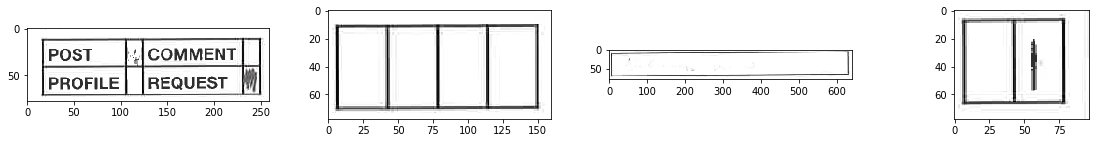

In [35]:
rows, cols = 1, 4

part_rois = docs_rois['a']['parts']

plt.figure(figsize=(20, 2))

for i, part_roi in enumerate(part_rois):
    
#     print i + 1
    
    part_type = part_roi.keys()[0]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(part_roi[part_type])

#### SPLIT TOTALS INTO QR CODE, DATE, AND TOTALS

In [ ]:
#### TODO: ADD ABILITY TO OPTIONALLY PASS X, Y PARAMS

In [ ]:
qr_code = get_qr_code(summary_img)
get_date_roi(summary_img)
split_date_roi(date_img)
get_totals_roi(summary_img)
split_totals_roi(totals_img)

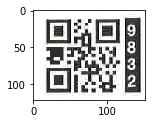

In [36]:
def get_qr_code_roi(summary_img):
    
    x1 = 0
    y1 = 0

    x2 = 152
    y2 = summary_img.shape[0]

    qr_code_img = summary_img[y1:y2, x1:x2]
    
#     print 'X1:', x1, 'Y1:', y1
#     print 'X2:', x2, 'Y2:', y2
#     print qr_code_img.shape
    
    return qr_code_img

qr_code_img = get_qr_code_roi(summary_img)
plt.figure(figsize = (2,2))
plt.imshow(qr_code_img)

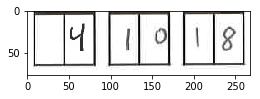

In [37]:
def get_date_roi(summary_img, crop_h=0):
    
    x1 = 152
    y1 = 0 + crop_h

    x2 = 420
    y2 = summary_img.shape[0]

    date_img = summary_img[y1:y2, x1:x2]
    
#     print 'X1:', x1, 'Y1:', y1
#     print 'X2:', x2, 'Y2:', y2
#     print date_img.shape
    
    return date_img

date_img = get_date_roi(summary_img, 45)
plt.figure(figsize = (4,4))
plt.imshow(date_img)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f788ff141d0>,
 <matplotlib.image.AxesImage at 0x7f78b81cf590>)

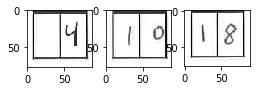

In [38]:
def split_date_roi(date_img):
    
    date_rois = OrderedDict()
    
    width = date_img.shape[1]/3 # DIVIDE WIDTH INTO THREE EQUAL PIECES
    x = [0, width, width * 2, date_img.shape[1]]
    y_top, y_bottom = 0, date_img.shape[0]
    
    date_rois['month_img'] = date_img[y_top:y_bottom, x[0]:x[1]]
    date_rois['day_img'] = date_img[y_top:y_bottom, x[1]:x[2]]
    date_rois['year_img'] = date_img[y_top:y_bottom, x[2]:x[3]]
    
#     print date_img.shape
    
    return date_rois

date_imgs = split_date_roi(date_img)

plt.figure(figsize = (4,4))
plt.subplots_adjust(hspace=.9)
plt.subplot(1, 3, 1), plt.imshow(date_imgs['month_img'])
plt.subplot(1, 3, 2), plt.imshow(date_imgs['day_img'])
plt.subplot(1, 3, 3), plt.imshow(date_imgs['year_img'])

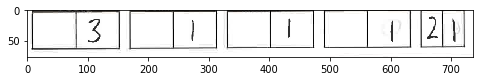

In [39]:
def get_totals_roi(summary_img, crop_h=0):
    
    x1 = 420
    y1 = 0 + crop_h

    x2 = summary_img.shape[1]
    y2 = summary_img.shape[0]

    totals_img = summary_img[y1:y2, x1:x2]
    
#     print 'X1:', x1, 'Y1:', y1
#     print 'X2:', x2, 'Y2:', y2
#     print date_img.shape
    
    return totals_img

totals_img = get_totals_roi(summary_img, 45)
plt.figure(figsize = (8,4))
plt.imshow(totals_img)

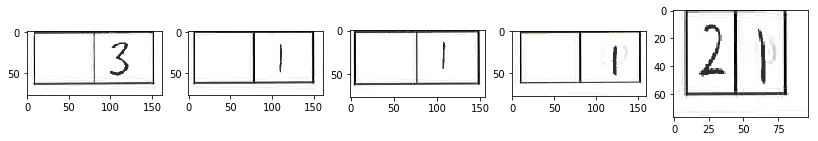

In [40]:
# TODO: MAKE INTO ORDERED DICT

def split_totals_roi(totals_img):
    
    totals_rois = OrderedDict()
    
    x = [0, 162, 324, 480, 640, totals_img.shape[1]]
    y_top, y_bottom = 0, totals_img.shape[0]
    
    totals_rois['posts_roi'] = totals_img[y_top:y_bottom, x[0]:x[1]]
    totals_rois['comments_roi'] = totals_img[y_top:y_bottom, x[1]:x[2]]
    totals_rois['requests_roi'] = totals_img[y_top:y_bottom, x[2]:x[3]]
    totals_rois['profiles_roi'] = totals_img[y_top:y_bottom, x[3]:x[4]]
    totals_rois['pages_roi'] = totals_img[y_top:y_bottom, x[4]:x[5]]
    
    return totals_rois

totals_roi_imgs = split_totals_roi(totals_img)

plt.figure(figsize = (14,2))

for i, (roi, img) in enumerate(totals_roi_imgs.items()):

    plt.subplot(1, 5, i + 1), plt.imshow(img)

#### RETREIVE HANDWRITING ANALYSIS FROM MICROSOFT

90

6


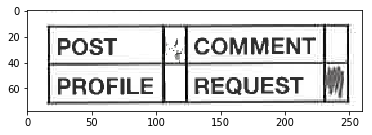

In [42]:
doc_rois = split_doc_rois(docs, widths)

post_a_type = doc_rois['a']['parts'][0]['type'].copy()
gray = cv2.cvtColor(post_a_type, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 2)
edged = cv2.Canny(blurred, 25, 30, True)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
im2, contours, hierarchy = cv2.findContours(edged,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

print len(contours)
quad_contours = []
coords = []
approxes = []

if len(contours) > 0:
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # loop over the sorted contours
    for contour in contours:
        # approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, .01 * peri, True)
        
        (x, y, w, h) = cv2.boundingRect(approx)
        area = w / float(h)
        
        

        # if our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            quad_contours.append(approx)
            coords.append((w, h, area))
#             if area >= .65 and area <= .75:
#                 quad_contours.append(approx)
    print ''
print len(quad_contours)
plt.imshow(post_a_type, 'gray')

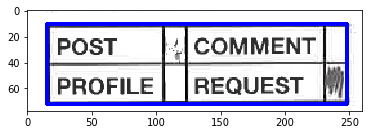

In [52]:
post_a = doc_rois['a']['parts'][0]['type'].copy()
gray = cv2.cvtColor(post_a_type, cv2.COLOR_BGR2GRAY)

cnt = quad_contours[0]
# plt.figure(figsize = (14,18))
# plt.imshow(cv2.drawContours(img, [cnt[3], cnt[1]], -1, (0,255,0), 20))

p1 = tuple(cnt[3][0])
p2 = tuple(cnt[1][0])
plt.imshow(cv2.rectangle(post_a, p1, p2, (0,0,255), 2))

(59, 235, 3)


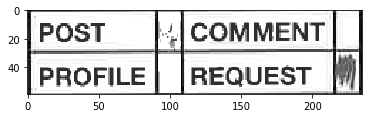

In [60]:
x1 = p1[0]
y1 = p1[1]

x2 = p2[0]
y2 = p2[1]

# print 'X1:', x1, 'Y1:', y1
# print 'X2:', x2, 'Y2:', y2

type_box = doc_rois['a']['parts'][0]['type'][y1:y2, x1:x2]
print type_box.shape
# plt.figure(figsize = (14,18))
plt.imshow(type_box)

(95, 3) (102, 27)
(223, 3) (232, 27)
(95, 33) (102, 56)
(223, 33) (232, 56)


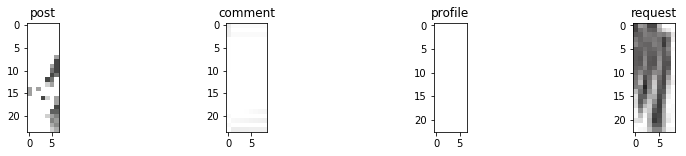

In [69]:
def split_type_box_rois(img):
    
    line = 3

    top = 0
    middle = int(math.ceil(type_box.shape[0]/2.0))
    bottom = type_box.shape[0]
    
    x = [92, 105, 220, type_box.shape[1]]
    y = [top, middle, bottom] # 5 is line thickness

    post_box = {'p1': (x[0] + line, y[0] + line), 'p2' : (x[1] - line, y[1] - line )} # (95, 0) (114, 31)
    comment_box = {'p1': (x[2] + line, y[0] + line), 'p2' : (x[3] - line, y[1] - line)} # (227, 0) (232, 31)
    profile_box = {'p1': (x[0] + line, y[1] + line), 'p2' : (x[1] - line, y[2] - line)} # (95, 31) (114, 61)
    request_box = {'p1': (x[2] + line, y[1] + line), 'p2' : (x[3] - line, y[2] - line)} # (227, 31) (232, 61)

    check_box_coords = [post_box, comment_box, profile_box, request_box]
    check_box_names = ['post', 'comment', 'profile', 'request']

    check_box_imgs = OrderedDict()

    for coord, name in zip(check_box_coords, check_box_names):

        
        x1 = coord['p1'][0]
        y1 = coord['p1'][1]

        x2 = coord['p2'][0]
        y2 = coord['p2'][1]
        
        check_box = type_box[y1:y2, x1:x2]
        
        check_box_imgs[name] = check_box
        
        print coord['p1'], coord['p2']
#         print x1, y1, x2, y2
        
    return check_box_imgs
        
#         

check_box_imgs = split_type_box_rois(type_box)

plt.figure(figsize = (14,2))
plt.tight_layout()

for i, (roi, img) in enumerate(check_box_imgs.items()):
    plt.subplot(1, 4, i + 1), plt.imshow(img)
    plt.title(roi)

request


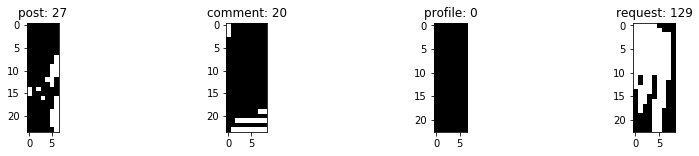

In [106]:
# https://stackoverflow.com/questions/4690094/sorting-dictionary-keys-based-on-their-values
    
def detect_post_type(cb_img_dict):
    
    cb_thresh_dict = OrderedDict()
    
    for name, img in cb_img_dict.items():
        
        cb = img.copy()
        gray = cv2.cvtColor(cb, cv2.COLOR_BGR2GRAY)
        ret, thresh_cb = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        non_zeros = cv2.countNonZero(thresh_cb)
        
        cb_thresh_dict[name] = {'thresh': thresh_cb, 'value' : non_zeros }
        
    sorted_dict = sorted(cb_thresh_dict, key=lambda k: cb_thresh_dict[k]['value'], reverse=True)
    
#     return sorted_dict[0]
    return sorted_dict[0], cb_thresh_dict # ONLY FOR DISPLAY PURPOSES

checked_box, thresh_dict = detect_post_type(check_box_imgs)

print checked_box

plt.figure(figsize = (14,2))
plt.tight_layout()

for i, (name, img_dict) in enumerate(thresh_dict.items()):
    plt.subplot(1, 4, i + 1), plt.imshow(img_dict['thresh'], 'gray')
    plt.title(name + ': ' + str(img_dict['value']))

#### TEST FOR BEST THRESHOLDING

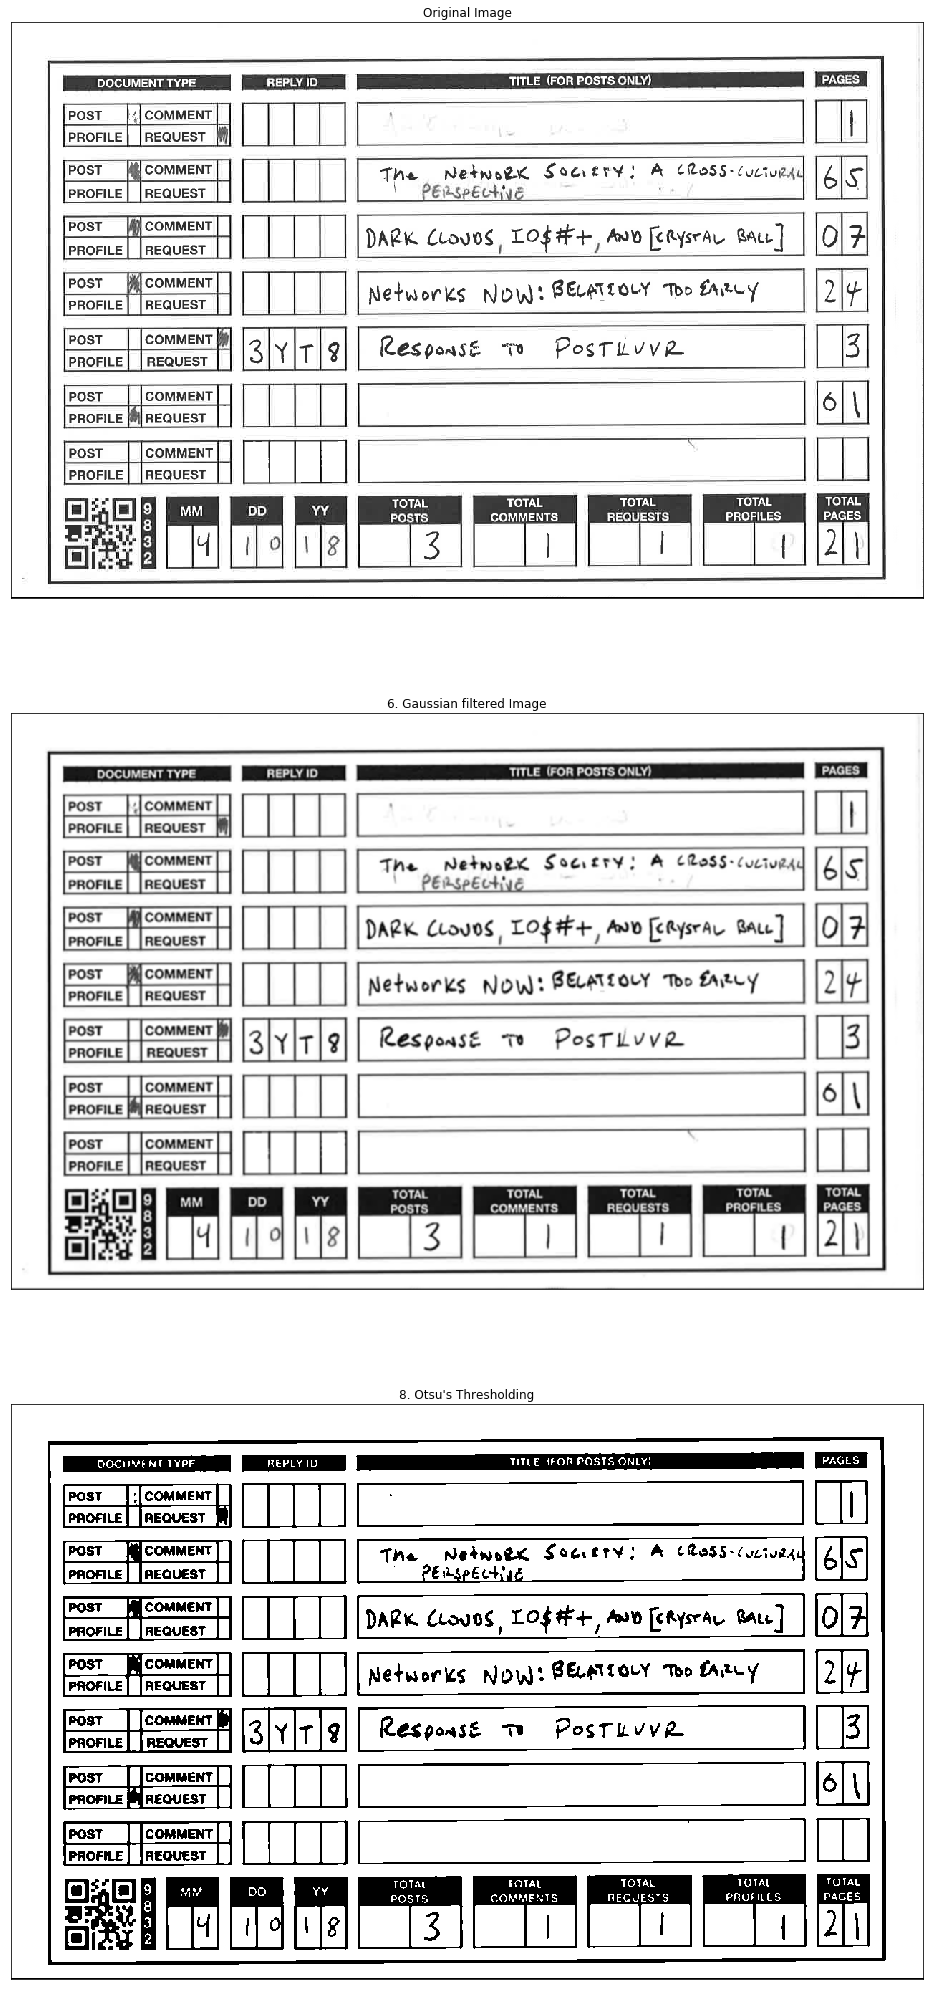

In [4]:
img = cv2.imread(img_loc + img_name, 0)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]

titles = ['0. Original Noisy Image','1. Histogram','2. Global Thresholding (v=127)',
          '3. Original Noisy Image','4. Histogram',"5. Otsu's Thresholding",
          '6. Gaussian filtered Image','7. Histogram',"8. Otsu's Thresholding"]

plt.figure(figsize = (28,36))

rows = 3
cols = 1

# print '6. Original'
plt.subplot(rows,cols,1),plt.imshow(img,'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

# print '6. Gaussian filtered Image'
plt.subplot(rows,cols,2),plt.imshow(images[6],'gray')
plt.title(titles[6]), plt.xticks([]), plt.yticks([])

# print "8. Otsu's Thresholding"
plt.subplot(rows,cols,3),plt.imshow(images[8],'gray')
plt.title(titles[8]), plt.xticks([]), plt.yticks([])
    
plt.show()

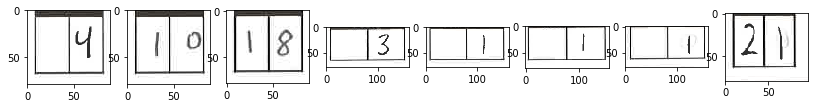

In [63]:
cropped_totals = []

for totals_img in totals_imgs:
    
    crop_h = 43
    
    y_top = 0 + crop_h
    y_bottom = totals_img.shape[0]
    
    x_left = 0
    x_right = totals_img.shape[1]
    
    cropped_total = totals_img[y_top:y_bottom, x_left:x_right]
    
    cropped_totals.append(cropped_total)
    
plt.figure(figsize=(14, 2))
for i, cropped_total in enumerate(cropped_totals):

    plt.subplot(1, 8, i + 1), plt.imshow(cropped_total)